In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 

In [2]:
train_lens_1 = np.load('/kaggle/input/gravitational-lens-finding-data/train_lenses/1.npy')
train_nonlens_1 = np.load('/kaggle/input/gravitational-lens-finding-data/train_nonlenses/1.npy')

In [3]:
print(f"Shape of Lensed Image:{train_lens_1.shape}")
print(f"Shape of Non Lensed Image: {train_nonlens_1.shape}")

Shape of Lensed Image:(3, 64, 64)
Shape of Non Lensed Image: (3, 64, 64)


In [4]:
train_lens_1 = np.transpose(train_lens_1,(1,2,0))
train_nonlens_1 = np.transpose(train_nonlens_1,(1,2,0))
print(f"Shape of Lensed Image:{train_lens_1.shape}")
print(f"Shape of Non Lensed Image: {train_nonlens_1.shape}")

Shape of Lensed Image:(64, 64, 3)
Shape of Non Lensed Image: (64, 64, 3)


(-0.5, 63.5, 63.5, -0.5)

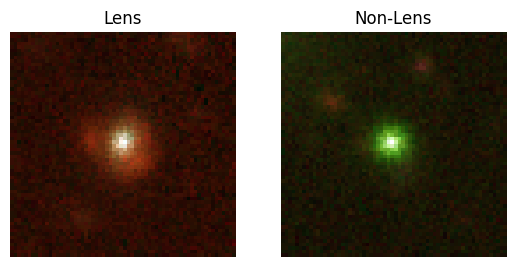

In [5]:
plt.subplot(1,2,1)
plt.imshow(train_lens_1)
plt.title("Lens")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(train_nonlens_1)
plt.title("Non-Lens")
plt.axis(False)


In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.metrics import roc_curve, auc


In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Custom Dataset with Advanced Preprocessing
class LensDataset(Dataset):
    def __init__(self, lenses_dir, non_lenses_dir, transform=None):
        self.data = []
        self.labels = []

        # Load lensed galaxies (label 1)
        for filename in os.listdir(lenses_dir):
            if filename.endswith('.npy'):
                image_path = os.path.join(lenses_dir, filename)
                image = np.load(image_path)
                self.data.append(image)
                self.labels.append(1)

        # Load non-lensed galaxies (label 0)
        for filename in os.listdir(non_lenses_dir):
            if filename.endswith('.npy'):
                image_path = os.path.join(non_lenses_dir, filename)
                image = np.load(image_path)
                self.data.append(image)
                self.labels.append(0)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

        # Advanced transform with data augmentation
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Handle 3-channel input for pre-trained models
        image = self.data[idx]

        # Repeat single channel across 3 channels if needed
        if image.shape[0] == 1:
            image = np.repeat(image, 3, axis=0)

        # Assuming input is (C, H, W), transpose to (H, W, C) for transforms
        image = image.transpose(1, 2, 0)

        # Apply transformations
        image = self.transform(image)

        return image, torch.tensor(self.labels[idx], dtype=torch.float32)



In [9]:
# Advanced Transfer Learning Model
class TransferLensClassifier(nn.Module):
    def __init__(self, base_model_name='resnet18', num_classes=1, dropout_rate=0.5):
        super().__init__()

        # Comprehensive model selection with weights=True instead of pretrained=True
        # This addresses deprecation warning in newer PyTorch versions
        model_dict = {
            'resnet18': models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
            'resnet50': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
            'densenet121': models.densenet121(weights=models.DenseNet121_Weights.DEFAULT),
            'efficientnet_b0': models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT),
            'mobilenet_v2': models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        }

        self.base_model = model_dict[base_model_name]

        # Dynamic feature extraction and classification head
        if 'resnet' in base_model_name:
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes),
                nn.Sigmoid()
            )
        elif 'densenet' in base_model_name:
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes),
                nn.Sigmoid()
            )
        elif 'efficientnet' in base_model_name:
            num_features = self.base_model.classifier[1].in_features
            self.base_model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes),
                nn.Sigmoid()
            )
        elif 'mobilenet' in base_model_name:
            num_features = self.base_model.classifier[1].in_features
            self.base_model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes),
                nn.Sigmoid()
            )

    def forward(self, x):
        return self.base_model(x)

In [10]:
def prepare_transfer_data(train_lenses_dir, train_nonlenses_dir,
                          test_lenses_dir, test_nonlenses_dir):
    # Create full dataset
    full_dataset = LensDataset(
        train_lenses_dir,  # Lensed galaxies
        train_nonlenses_dir  # Non-lensed galaxies
    )

    # Split data into train and test sets (90:10)
    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, test_size]
    )

    # Create weighted samplers
    def create_weighted_sampler(dataset, full_labels):
        # Extract labels for the subset
        subset_indices = dataset.indices
        subset_labels = full_labels[subset_indices]

        class_counts = np.bincount(subset_labels.astype(int))
        class_weights = 1. / class_counts
        sample_weights = class_weights[subset_labels.astype(int)]

        return WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(dataset),
            replacement=True
        )

    # Further split training data into training and validation (80:20 of the 90%)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        sampler=create_weighted_sampler(train_dataset, full_dataset.labels)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        sampler=create_weighted_sampler(val_dataset, full_dataset.labels)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        sampler=create_weighted_sampler(test_dataset, full_dataset.labels)
    )

    # Print dataset sizes for verification
    print(f"Total dataset size: {len(full_dataset)}")
    print(f"Training dataset size: {len(train_dataset)} (72% of total)")
    print(f"Validation dataset size: {len(val_dataset)} (18% of total)")
    print(f"Test dataset size: {len(test_dataset)} (10% of total)")

    return train_loader, val_loader, test_loader

In [11]:
def train_with_best_params(train_loader, val_loader, test_loader, best_params, num_epochs=20):
    # Create model with best parameters
    model = TransferLensClassifier(
        base_model_name=best_params['model_name'],
        dropout_rate=best_params['dropout_rate']
    )
    
    # The critical fix: Ensure all parameters require gradients before applying freezing
    for param in model.parameters():
        param.requires_grad = True
    
    # Apply layer freezing if specified in best params
    if best_params.get('freeze_layers', False):
        # Freeze base model parameters
        for name, param in model.base_model.named_parameters():
            # Skip the classification layers which we'll ensure have requires_grad=True below
            if 'fc' not in name and 'classifier' not in name:
                param.requires_grad = False
    
    # Double-check that at least some parameters require gradients
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    if trainable_params == 0:
        raise ValueError("No trainable parameters in the model! Cannot train.")
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),  # Only optimize parameters that require gradients
        lr=best_params['learning_rate'],
        weight_decay=best_params.get('weight_decay', 0)
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    model.to(device)
    
    # Training history
    training_history = []
    best_auc = 0
    best_model_state = None
    
    print("Training with best parameters:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_losses = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation Phase
        model.eval()
        val_preds = []
        val_labels = []
        val_losses = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_losses.append(loss.item())
        
        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(val_labels, val_preds)
        val_auc = auc(fpr, tpr)
        
        # Learning rate scheduling
        scheduler.step(val_auc)
        
        # Tracking and logging
        epoch_stats = {
            'epoch': epoch + 1,
            'train_loss': np.mean(train_losses),
            'val_loss': np.mean(val_losses),
            'val_auc': val_auc
        }
        training_history.append(epoch_stats)
        
        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_state = model.state_dict().copy()
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_stats['train_loss']:.4f}")
        print(f"Val Loss: {epoch_stats['val_loss']:.4f}")
        print(f"Val AUC: {val_auc:.4f}")
    
    # Save training history
    history_df = pd.DataFrame(training_history)
    os.makedirs('saved_models', exist_ok=True)
    history_df.to_csv(os.path.join('saved_models', f'training_history_best_params_auc_{best_auc:.4f}.csv'), index=False)
    
    # Save best model
    best_model_path = os.path.join('saved_models', f'best_model_auc_{best_auc:.4f}.pth')
    torch.save({
        'model_state_dict': best_model_state,
        'auc': best_auc,
        'config': best_params
    }, best_model_path)
    
    # Evaluate on test set
    model.load_state_dict(best_model_state)
    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_preds.extend(outputs.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    # Compute test ROC and AUC
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    test_auc = auc(fpr, tpr)
    
    print(f"\nFinal Results:")
    print(f"Best Validation AUC: {best_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('test_roc_curve.png')
    plt.close()
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot([stat['epoch'] for stat in training_history], 
             [stat['train_loss'] for stat in training_history], label='Train Loss')
    plt.plot([stat['epoch'] for stat in training_history], 
             [stat['val_loss'] for stat in training_history], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot([stat['epoch'] for stat in training_history], 
             [stat['val_auc'] for stat in training_history], label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    
    return best_auc, test_auc, best_model_path

In [12]:
# Main Execution
def main():
    # Specify directories (update these paths)
    train_lenses_dir = '/kaggle/input/gravitational-lens-finding-data/train_lenses'
    train_nonlenses_dir = '/kaggle/input/gravitational-lens-finding-data/train_nonlenses'
    test_lenses_dir = '/kaggle/input/gravitational-lens-finding-data/test_lenses'
    test_nonlenses_dir = '/kaggle/input/gravitational-lens-finding-data/test_nonlenses'

    # Prepare data
    train_loader, val_loader, test_loader = prepare_transfer_data(
        train_lenses_dir,
        train_nonlenses_dir,
        test_lenses_dir,
        test_nonlenses_dir
    )

    # Define best parameters (replace with your actual best parameters)
    best_params = {
         'model_name': 'resnet50',
         'learning_rate': 1e-05,
         'weight_decay': 0.0,
         'dropout_rate': 0.3,
         'freeze_layers': False

    }

    # Train with best parameters
    val_auc, test_auc, model_path = train_with_best_params(
        train_loader, 
        val_loader, 
        test_loader, 
        best_params,
        num_epochs=30  # Set your desired number of epochs
    )
    
    print("\nTraining completed!")
    print(f"Best Validation AUC: {val_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Best model saved to: {model_path}")

if __name__ == '__main__':
    main()

Total dataset size: 30405
Training dataset size: 21891 (72% of total)
Validation dataset size: 5473 (18% of total)
Test dataset size: 3041 (10% of total)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 215MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 231MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 197MB/s]
/usr/local/lib/python3.10/d

Trainable parameters: 24,690,241 (100.00% of total)
Training with best parameters:
model_name: resnet50
learning_rate: 1e-05
weight_decay: 0.0
dropout_rate: 0.3
freeze_layers: False
Epoch 1/30
Train Loss: 0.4788
Val Loss: 0.4098
Val AUC: 0.9158
Epoch 2/30
Train Loss: 0.3047
Val Loss: 0.2904
Val AUC: 0.9555
Epoch 3/30
Train Loss: 0.2046
Val Loss: 0.2189
Val AUC: 0.9648
Epoch 4/30
Train Loss: 0.1514
Val Loss: 0.1476
Val AUC: 0.9620
Epoch 5/30
Train Loss: 0.1136
Val Loss: 0.1300
Val AUC: 0.9743
Epoch 6/30
Train Loss: 0.0888
Val Loss: 0.1062
Val AUC: 0.9803
Epoch 7/30
Train Loss: 0.0729
Val Loss: 0.0887
Val AUC: 0.9847
Epoch 8/30
Train Loss: 0.0631
Val Loss: 0.0916
Val AUC: 0.9626
Epoch 9/30
Train Loss: 0.0553
Val Loss: 0.0837
Val AUC: 0.9706
Epoch 10/30
Train Loss: 0.0496
Val Loss: 0.0892
Val AUC: 0.9746
Epoch 11/30
Train Loss: 0.0454
Val Loss: 0.0770
Val AUC: 0.9831
Epoch 12/30
Train Loss: 0.0393
Val Loss: 0.0681
Val AUC: 0.9800
Epoch 13/30
Train Loss: 0.0381
Val Loss: 0.0712
Val AUC: 0.